# Hyperparameter Tuning

In this notebook, we perform hyperparameter tuning for XGBoost and Random Forest models, using Bayesian optimization. To prevent overfitting, we only tune a few variables. We perform this process for all 4 output variables. We present the models performance in graphs. We save the best models for our simulation analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor, XGBRFRegressor
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import joblib

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data Import

In [2]:
data = pd.read_csv('data/data.csv')

<ipython-input-2-e9bba6ebf1b5>:1: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/data.csv')


In [3]:
data['Clim_zone'] = data['Clim_zone'].astype('category')
data['Coastal?'] = data['Coastal?'].astype('category')

In [4]:
features = ['Built Area (%)', 'Grass Area (%)', 'Tree Area (%)', 
            'Albedo_Built', 'Albedo_Grass', 'Albedo_Tree', 
            'DEM_urb_CT_act', 'Clim_zone', 'Coastal?']

## Bayesian Optimization Set-up

In [5]:
def tune(xgb=True):
    # Hyperparameter space
    space = {'n_estimators': hp.quniform('n_estimators', 50, 150, 1),
             'max_depth': hp.quniform('max_depth', 10, 20, 1),
    }
    
    def objective(space):
        if xgb==True:
            clf = XGBRegressor(
                            n_estimators = int(space['n_estimators']), 
                            max_depth = int(space['max_depth']), 
                            grow_policy='lossguide', enable_categorical=True, tree_method='hist'
            )
        else:
            clf = XGBRFRegressor(
                            n_estimators = int(space['n_estimators']), 
                            max_depth = int(space['max_depth']), 
                            grow_policy='lossguide', enable_categorical=True, tree_method='hist'
            )

        clf.fit(X_train, y_train, eval_set = eval_set, verbose=False)

        pred = clf.predict(X_test)
        
        rmse = mean_squared_error(y_test, pred, squared = False)
        return {'loss': rmse, 'status': STATUS_OK }

    # Hyperparameter Tuning
    trials = Trials()
    
    best_hyperparams = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials)
    
    best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])
    best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])

    print("The best hyperparameters are : ","\n")
    print(best_hyperparams)

    # Model with early stopping
    if xgb==True:
        model = XGBRegressor(eval_metric = ['rmse'], importance_type='gain', random_state=1, 
                             enable_categorical=True, tree_method='hist',
                             grow_policy = 'lossguide')
    else:
        model = XGBRFRegressor(eval_metric = ['rmse'], importance_type='gain', random_state=1, 
                               enable_categorical=True, tree_method='hist',
                               grow_policy = 'lossguide')

    model.set_params(**best_hyperparams)
    
    model.fit(X_train, y_train, eval_set = eval_set, verbose = False)

    # make predictions for test data
    y_pred = model.predict(X_test)

    print('R2: ', r2_score(y_test, y_pred))
    print('Root Mean Squared Error: ', mean_squared_error(y_test, y_pred, squared = False))
    
    return model, r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred, squared = False)

## Data Helper Function

In [6]:
def get_data(label):
    df = data.dropna()
    X = df[features]
    y = df[label]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40,  random_state=1, shuffle=True) 
    X_test, X_val, y_test, y_val = train_test_split(X, y, test_size=0.5,  random_state=1, shuffle=True) 

    eval_set = [(X_train, y_train), (X_val, y_val)]
    
    return X_train, X_test, y_train, y_test, X_val, y_val, eval_set

## Train and save models

In [7]:
labels = ['CUHI_day_summer', 'CUHI_night_summer', 'SUHI_day_summer', 'SUHI_night_summer']

In [8]:
r2_scores = []
rmse_scores = []

### XGBoost Estimators

In [9]:
for l in labels:
    print(l)
    X_train, X_test, y_train, y_test, X_val, y_val, eval_set = get_data(l)
    model, r2, rmse = tune()
    r2_scores.append(round(r2,5))
    rmse_scores.append(round(rmse,5))
    # Save the estimator
    joblib.dump(model, 'models/' + l + '_xgb_estimator.joblib') 
    print()

CUHI_day_summer
100%|██████████| 100/100 [27:41<00:00, 16.61s/trial, best loss: 0.0013093865554590594]
The best hyperparameters are :  

{'max_depth': 19, 'n_estimators': 150}
R2:  0.9999963543651675
Root Mean Squared Error:  0.0013093865554590594

CUHI_night_summer
100%|██████████| 100/100 [26:55<00:00, 16.15s/trial, best loss: 0.0014313595333767517]
The best hyperparameters are :  

{'max_depth': 20, 'n_estimators': 150}
R2:  0.9999932361759262
Root Mean Squared Error:  0.0014313595333767517

SUHI_day_summer
100%|██████████| 100/100 [32:58<00:00, 19.79s/trial, best loss: 0.0012590667764107752]
The best hyperparameters are :  

{'max_depth': 20, 'n_estimators': 80}
R2:  0.9999998215703927
Root Mean Squared Error:  0.0012590667764107752

SUHI_night_summer
100%|██████████| 100/100 [52:19<00:00, 31.40s/trial, best loss: 0.001375542257913648] 
The best hyperparameters are :  

{'max_depth': 19, 'n_estimators': 80}
R2:  0.9999979998341478
Root Mean Squared Error:  0.001375542257913648



### Random Forest Estimators

In [10]:
for l in labels:
    print(l)
    X_train, X_test, y_train, y_test, X_val, y_val, eval_set = get_data(l)
    model, r2, rmse = tune(False)
    r2_scores.append(round(r2,5))
    rmse_scores.append(round(rmse,5))
    # Save the estimator
    joblib.dump(model, 'models/' + l + '_rf_estimator.joblib') 
    print()

CUHI_day_summer
100%|██████████| 100/100 [15:33:06<00:00, 559.86s/trial, best loss: 0.12901711069201427]   
The best hyperparameters are :  

{'max_depth': 20, 'n_estimators': 141}
R2:  0.965315300964771
Root Mean Squared Error:  0.12771745622293879

CUHI_night_summer
100%|██████████| 100/100 [3:03:28<00:00, 110.09s/trial, best loss: 0.09763157889806937] 
The best hyperparameters are :  

{'max_depth': 20, 'n_estimators': 146}
R2:  0.9683893260798102
Root Mean Squared Error:  0.09785194459975809

SUHI_day_summer
100%|██████████| 100/100 [3:16:22<00:00, 117.82s/trial, best loss: 0.5597205423210685] 
The best hyperparameters are :  

{'max_depth': 20, 'n_estimators': 149}
R2:  0.9643055804816865
Root Mean Squared Error:  0.5631388195557668

SUHI_night_summer
100%|██████████| 100/100 [7:48:59<00:00, 281.39s/trial, best loss: 0.2098414869970935]  
The best hyperparameters are :  

{'max_depth': 20, 'n_estimators': 148}
R2:  0.953788654812832
Root Mean Squared Error:  0.20908132226502374



In [11]:
r2_scores

[1.0, 0.99999, 1.0, 1.0, 0.96532, 0.96839, 0.96431, 0.95379]

In [12]:
rmse_scores

[0.00131, 0.00143, 0.00126, 0.00138, 0.12772, 0.09785, 0.56314, 0.20908]

## Model Performance
Here, we present the model's performance, using r-squared and RMSE as our metrics. We further plot the actual versus predicted test set against a 'perfect' model.

In [13]:
models = ['CUHI_day_summer_xgb_estimator.joblib', 'CUHI_night_summer_xgb_estimator.joblib',
          'SUHI_day_summer_xgb_estimator.joblib', 'SUHI_night_summer_xgb_estimator.joblib',
          'CUHI_night_summer_rf_estimator.joblib', 'CUHI_day_summer_rf_estimator.joblib',
          'SUHI_day_summer_rf_estimator.joblib', 'SUHI_night_summer_rf_estimator.joblib']

In [14]:
titles = ['CUHI Day (XGBoost)', 'CUHI Night (XGBoost)', 'SUHI Day (XGBoost)', 'SUHI Night (XGBoost)', 
          'CUHI Day (Random Forest)', 'CUHI Night (Random Forest)', 'SUHI Day (Random Forest)', 'SUHI Night (Random Forest)']

In [15]:
labelsx2 = ['CUHI_day_summer', 'CUHI_night_summer', 'SUHI_day_summer', 'SUHI_night_summer', 
            'CUHI_day_summer', 'CUHI_night_summer', 'SUHI_day_summer', 'SUHI_night_summer']

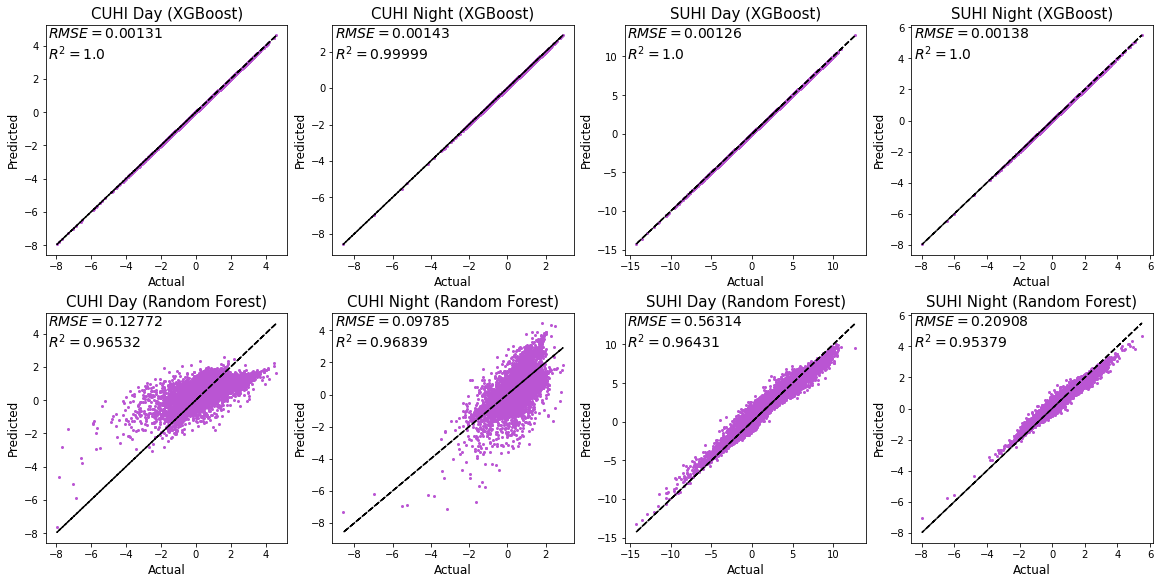

In [16]:
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(16,8), constrained_layout=True)

for k, ax in enumerate(axes.flatten()):
    estimator = joblib.load('models/' + models[k]) 
    X_train, X_test, y_train, y_test, X_val, y_val, eval_set = get_data(labelsx2[k])
    y_pred1 = estimator.predict(X_test)
    ax.text(.01, .99, '$RMSE={}$ \n$R^2={}$'.format(rmse_scores[k],r2_scores[k]), ha='left', va='top', transform=ax.transAxes, fontsize=14)
    ax.plot(y_test, y_test, linestyle='dashed', color='black')
    ax.scatter(y_test, y_pred1, color='mediumorchid', s=4)
    ax.set_xlabel('Actual', fontsize=12)
    ax.set_ylabel('Predicted', fontsize=12)
    ax.set_title(titles[k],fontsize=15)
plt.savefig('graphs/performance/model_performance_all.png', bbox_inches='tight', dpi=720)

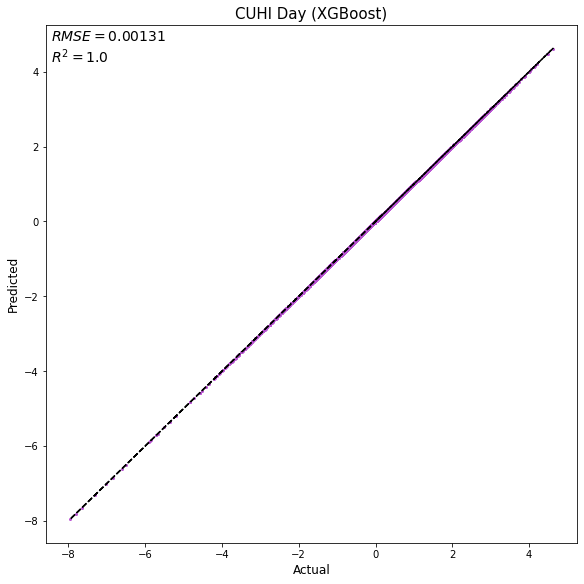

In [18]:
fig, ax = plt.subplots(figsize=(8,8), constrained_layout=True)

estimator = joblib.load('models/' + models[0]) 
X_train, X_test, y_train, y_test, X_val, y_val, eval_set = get_data(labelsx2[0])
y_pred1 = estimator.predict(X_test)
ax.text(.01, .99, '$RMSE={}$ \n$R^2={}$'.format(rmse_scores[0],r2_scores[0]), ha='left', va='top', transform=ax.transAxes, fontsize=14)
ax.plot(y_test, y_test, linestyle='dashed', color='black')
ax.scatter(y_test, y_pred1, color='mediumorchid', s=4)
ax.set_xlabel('Actual', fontsize=12)
ax.set_ylabel('Predicted', fontsize=12)
ax.set_title(titles[0],fontsize=15)
plt.savefig('graphs/performance/model_performance_cuhi_day_xgb.png', bbox_inches='tight', dpi=720)